In [1]:
from layout import get_layout
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from genetic_algo_preparation import Floorplanning, RecordBsfCosts

In [2]:
df = pd.read_csv('../refined_drug_data.csv', sep=';')
# all NaN to empty string
df = df.fillna('')

data = df.copy()
# make an array
data['drug_names'] = data[['Drug_1', 'Drug_2', 'Drug_3', 'Drug_4', 'Drug_5', 'Drug_6', 'Drug_7', 'Drug_8']].values.tolist()
# remove empty strings
data['drug_names'] = data['drug_names'].apply(lambda x: [i for i in x if i])
data = data.drop(['Drug_1', 'Drug_2', 'Drug_3', 'Drug_4', 'Drug_5', 'Drug_6', 'Drug_7', 'Drug_8'], axis=1)
data

print('Total number of combinations:', len(data))
print('Number of unique drugs:', len(data['drug_names'].explode().unique()))

# sort by freq 
sorted_drug_names = data['drug_names'].explode().value_counts().index
print('Sorted medications by frequency:', sorted_drug_names)
print('Frequency of each medication:', data['drug_names'].explode().value_counts().to_list())

Total number of combinations: 912
Number of unique drugs: 40
Sorted medications by frequency: Index(['LISINOPRIL', 'SIMVASTATIN', 'METOPROLOL', 'METFORMIN', 'LEVOTHYROXINE',
       'AMLODIPINE', 'HYDROCHLOROTHIAZIDE', 'FUROSEMIDE', 'ATORVASTATIN',
       'OMEPRAZOLE', 'ATENOLOL', 'GLIPIZIDE', 'ALBUTEROL', 'WARFARIN',
       'ASPIRIN', 'POTASSIUM CHLORIDE', 'ESOMEPRAZOLE', 'CLOPIDOGREL',
       'CARVEDILOL', 'VALSARTAN', 'LOSARTAN', 'GABAPENTIN', 'ROSUVASTATIN',
       'LOVASTATIN', 'PIOGLITAZONE', 'PRAVASTATIN', 'RANITIDINE', 'TRAMADOL',
       'IBUPROFEN', 'INSULIN GLARGINE', 'CITALOPRAM', 'ALENDRONATE',
       'ALLOPURINOL', 'MONTELUKAST', 'FEXOFENADINE', 'TAMSULOSIN', 'ZOLPIDEM',
       'SERTRALINE', 'FLUTICASONE NASAL', 'PREDNISONE'],
      dtype='object')
Frequency of each medication: [294, 270, 223, 215, 170, 159, 157, 133, 133, 127, 123, 98, 82, 81, 75, 72, 65, 65, 63, 62, 55, 54, 54, 52, 50, 48, 48, 46, 43, 42, 42, 42, 39, 34, 33, 32, 32, 32, 29, 28]


In [3]:
layout = 'doubleline_4_enter_60'

amount_of_machines = 60
INLETS_NUM = 4

# generated distribution from 14_05_2024.ipynb file
# machines_count = [4, 3, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] # 50 machines
# machines_count = [14, 11, 9, 5, 4, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] # 80 machines
machines_count = [5, 5, 5, 4, 4, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
assert sum(machines_count) == amount_of_machines, f"Sum of machines count is not equal to amount of machines: {sum(machines_count)} != {amount_of_machines}"

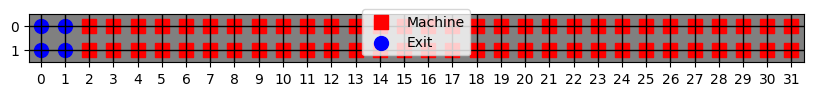

In [4]:
coord_x, coord_y, restricted_area, all_posible_positions = get_layout(layout)

exit_positions = all_posible_positions[:INLETS_NUM]
machine_positions = all_posible_positions[INLETS_NUM:]

plt.figure(figsize=(10, 10))
plt.imshow(restricted_area.transpose(), cmap='gray', alpha=0.5)
plt.scatter(*zip(*machine_positions), c='r', s=100, marker='s', label='Machine')
plt.scatter(*zip(*exit_positions), c='b', s=100, marker='o', label='Exit')
plt.xticks(range(coord_x))
plt.yticks(range(coord_y))

plt.legend()

plt.grid(which='major', color='k', linestyle='-', linewidth=1)
plt.show()

In [5]:
# read csv
coocurrence_matrix = np.loadtxt('../normalized_coocurrence_matrix.csv', delimiter=',')

In [6]:
# Prepare problem
# drug_names = data['drug_names'].explode().value_counts().index

# All distances between all possible positions. (distances[i, j] = distance between i-th and j-th position)
num_of_positions = len(all_posible_positions)
distances = np.zeros((num_of_positions, num_of_positions))
for i in range(num_of_positions):
    for j in range(num_of_positions):
        distances[i, j] = np.abs(all_posible_positions[i][0] - all_posible_positions[j][0]) + np.abs(all_posible_positions[i][1] - all_posible_positions[j][1])

# Create array of recepts where each drug is index in drug_names
capsules = []
for i in range(len(data)):
    capsules.append([sorted_drug_names.to_list().index(drug) for drug in data['drug_names'][i]])

# Make np array (for that make the same size recepts (place 0))
max_len = max([len(capsule) for capsule in capsules])
for i in range(len(capsules)):
    capsules[i] = capsules[i] + [-1] * (max_len - len(capsules[i]))
np_capsules = np.array(capsules)

In [7]:
# perm = range(40)

# Create a chromosome. Counts of machines in sorted_drug_names are given by machines_count. Create an array of machines (machines_count times each drug)
chromosome = np.array([drug for drug, count in zip(sorted_drug_names, machines_count) for _ in range(count)])
chromosome = np.array([sorted_drug_names.to_list().index(drug) for drug in chromosome])

# Add exit positions to machines_chromosome
chromosome = np.concatenate((chromosome, np.array([-10] * INLETS_NUM)))
chromosome

array([  0,   0,   0,   0,   0,   1,   1,   1,   1,   1,   2,   2,   2,
         2,   2,   3,   3,   3,   3,   4,   4,   4,   4,   5,   5,   6,
         6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
        19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
        32,  33,  34,  35,  36,  37,  38,  39, -10, -10, -10, -10])

#### Run Genetic Algorithm

In [8]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.crossover.ox import OrderCrossover
from pymoo.operators.mutation.inversion import InversionMutation
from pymoo.termination import get_termination
from pymoo.optimize import minimize

In [9]:
population_size = 50

perm = range(len(chromosome))
init_population = np.zeros((population_size, len(chromosome)))
for i in range(population_size):
    init_population[i] = np.random.permutation(perm)

problem = Floorplanning(perm, chromosome, np_capsules, distances, layout, coocurrence_matrix)

In [10]:
algorithm = GA(
    pop_size=population_size, 
    eliminate_duplicates=True, 
    sampling=init_population, 
    crossover=OrderCrossover(), 
    mutation=InversionMutation(), 
    # termination=get_termination("n_gen", 50)
)
n_eval = 10 # 25000 / 50 = 500 generations
print(f'Number of evaluations: {n_eval}, generations: {n_eval/population_size}')
termination = get_termination("n_eval", n_eval) 
res = minimize(
    problem,
    algorithm,
    termination,
    save_history=True,
    callback=RecordBsfCosts(),
    # seed=1,
)
# unique datetime for saving
import datetime
now = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
print("date: ", now)

Number of evaluations: 10, generations: 0.2
date:  20240828102605


In [11]:
print('Cost (through all recepts): ', res.F)
print('Permutation: ', res.X)
print('Number of iterations (for population, not candidate): ', res.history.__len__())

Cost (through all recepts):  [2821.82369202]
Permutation:  [39. 51. 38. 28. 12. 11.  3.  6. 14. 20.  7. 17. 16. 24. 18. 25. 33. 36.
 30. 29. 37. 41. 42. 31. 46. 53. 44. 35. 48. 45. 49. 15. 50. 22. 43. 19.
  0. 34. 40. 10. 32. 26. 23.  8. 52. 47.  5.  1.  9.  4. 21. 27. 13.  2.]
Number of iterations (for population, not candidate):  200


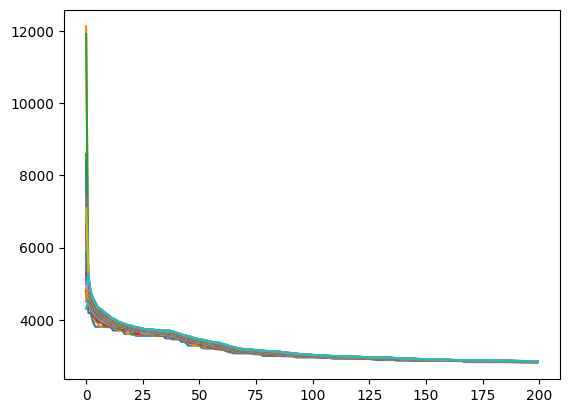

In [12]:
# plot best so far costs line ([i.reshape(-1) for i in res.algorithm.callback.data['bsf_costs']])
plt.figure()
# plt.plot([i.reshape(-1) for i in res.algorithm.callback.data['bsf_costs']]) min 
plt.plot([i.reshape(-1) for i in res.algorithm.callback.data['bsf_costs']])
plt.show()

In [42]:
# np.savez(f'../results/{layout}_{n_eval}_popsize_{population_size}_order_inversion_{now}.npz', 
#     layout=layout, 
#     population_size=population_size, 
#     inlet_positions=exit_positions,

#     machine_positions=machine_positions,
#     machines_drug_names=np.array([sorted_drug_names[drug] for drug in chromosome]),

#     gen_best_cost=res.F, 
#     gen_best_perm=res.X, # permutation of idxs of machines_drug_names
#     n_eval=n_eval,
#     bsf_costs=[i.reshape(-1) for i in res.algorithm.callback.data['bsf_costs']],
#     gen_description= f'Number of evaluations: {n_eval}, generations: {n_eval/population_size}, operator: OrderCrossover, InversionMutation',
# )
# now

'20240827171221'

In [13]:
idx_of_outlets = np.where(chromosome[res.X.astype(int)] == -10)[0]
inlet_positions = np.array(all_posible_positions)[idx_of_outlets]
inlet_positions_as_tuples = [tuple(i) for i in inlet_positions]
machines_idxs = [pos for pos in all_posible_positions if pos not in inlet_positions_as_tuples]

np.savez(f'../results/{layout}_{n_eval}_popsize_{population_size}_order_inversion_{now}.npz', 
    layout=layout, 
    population_size=population_size, 
    inlet_positions=np.array(all_posible_positions)[idx_of_outlets],
    machine_positions=[pos for pos in all_posible_positions if pos not in inlet_positions_as_tuples],
    machines_drug_names=np.array([sorted_drug_names[drug] for drug in chromosome if drug != -10]),

    gen_best_cost=res.F, 
    gen_best_perm=res.X[res.X < amount_of_machines], # permutation of idxs of machines_drug_names
    n_eval=n_eval,
    bsf_costs=[i.reshape(-1) for i in res.algorithm.callback.data['bsf_costs']],
    gen_description= f'Number of evaluations: {n_eval}, generations: {n_eval/population_size}, operator: OrderCrossover, InversionMutation',
)
now

'20240827223454'